In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer
from tensorflow.keras import layers
import os

In [2]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [3]:
def predictor(path):

  # Read the CSV file
  df = pd.read_csv(path,index_col='Date',parse_dates=True)
  close_df = df[['Close']]
  close_df.columns = ['y']
  n_features=1
  n_inputs=5
  X1, y1 = df_to_X_y(close_df, n_inputs)
  split_index=300

  X_train1, y_train1 = X1[split_index:], y1[split_index:]
  X_val1, y_val1 = X1[:split_index], y1[:split_index]
  # Creating a model instance and training it on the train data
  model2 = Sequential()
  model2.add(InputLayer((5, 1)))
  model2.add(Conv1D(128, kernel_size=2))
  model2.add(Flatten())
  model2.add(Dense(8, 'relu'))
  model2.add(Dense(1, 'linear'))
  cp2 = ModelCheckpoint('model2/', save_best_only=True)
  model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
  model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1, callbacks=[cp2])
  
  from tensorflow.keras.models import load_model
  model2 = load_model('model2/')

  test_predictions = []

  first_eval_batch = X_train1[-1:]
  # print(first_eval_batch.shape)
  current_batch = first_eval_batch.reshape((1, n_inputs , n_features))

  for i in range(100):
    current_pred = model2.predict(current_batch)[0]

    test_predictions.append(current_pred[0])

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# print(test_predictions.shape)
  # Predicting closing price for next 100 days
#   prediction_dates = model.make_future_dataframe(periods=100)
#   prediction_dates = prediction_dates.tail(100)
#   predictions = model.predict(prediction_dates) # predictions is also a dataframe

  # Creating the required format for the submission file
  pred_df=pd.DataFrame(columns=['Date','Price'])
  pred_df['Price']=test_predictions

  ids=[]
  for index, row in pred_df.iterrows():
    ID = f"{os.path.splitext(os.path.basename(path))[0]}_#{index+1}"
    ids.append(ID)

  pred_df['Date'] = ids

  return pred_df

In [4]:
# prediction=predictor(r'C:\Users\risha\Desktop\mine-the-model-2023\TRAIN\003.csv')

In [6]:
folder_path = r"C:\Users\risha\Desktop\mine-the-model-2023\New folder"
dfs=[]

# Passing each CSV file in the defined function to generate prices for each stock
for filename in os.listdir(folder_path):
  stock_df = os.path.join(folder_path,filename)
  dfs.append(predictor(stock_df))

67/85 [======================>.......] - ETA: 0s - loss: 2958.7317 - root_mean_squared_error: 54.3942  INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


85/85 [==============================] - 2s 13ms/step - loss: 2360.6687 - root_mean_squared_error: 48.5867 - val_loss: 23.1390 - val_root_mean_squared_error: 4.8103
(1, 5, 1, 1)
67/85 [======================>.......] - ETA: 0s - loss: 17885.8398 - root_mean_squared_error: 133.7379INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


85/85 [==============================] - 1s 9ms/step - loss: 15212.7822 - root_mean_squared_error: 123.3401 - val_loss: 24187.4453 - val_root_mean_squared_error: 155.5231
(1, 5, 1, 1)
72/85 [========================>.....] - ETA: 0s - loss: 1805.2725 - root_mean_squared_error: 42.4885INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


85/85 [==============================] - 1s 10ms/step - loss: 1776.7192 - root_mean_squared_error: 42.1511 - val_loss: 59.2946 - val_root_mean_squared_error: 7.7003
(1, 5, 1, 1)
1/1 [==============================] - 0s 41ms/step


In [9]:
dfsconcat = pd.concat(dfs)
dfsconcat.columns = ['ID','Price']
dfsconcat.to_csv('Submission_final.csv',index=False)

Text(0, 0.5, 'Closing Price')

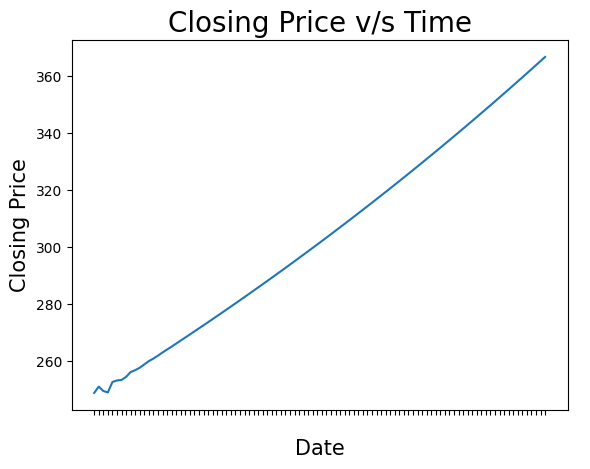

In [10]:
plt.plot(dfsconcat['ID'][0:100],dfsconcat['Price'][0:100])
plt.title('Closing Price v/s Time',size=20)
plt.xticks(c='white')
plt.xlabel('Date',size=15,)
plt.ylabel('Closing Price',size=15)